## Know your libraries (KYL)

In [1]:
import sys
sys.path.append('../../../src')

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import dataset, molecular_representation, config, utils, model
from dataset import QM9Dataset,LogSDataset,LogPDataset,FreeSolvDataset,ESOLDataset,ToxQDataset
import numpy as np
import pandas as pd
from utils import *
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from model import AtomAutoencoder,BondAutoencoder
from model import GNNBondAngle,GNN2D,GNN3D,GNN3DAtnON,GNN3DAtnOFF,GNN3Dihed,GNN3DConfig,GNN3DLayer,GNN3DClassifier

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addStereoAnnotation = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

import os
datadir="../../../data/regression/esol/"
modeldir="./models/"
dataset_name="esol"
# Create datadir and modeldir folders if they don't exist
if not os.path.exists(datadir):
    os.makedirs(datadir)

if not os.path.exists(modeldir):
    os.makedirs(modeldir)

import time
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Split your dataset (SYD)

In [2]:
# Load dataset from CSV
dataset = pd.read_csv(datadir+dataset_name+".csv")

# Split dataset into train and test
train_dataset, test_dataset = split_dataset(dataset, 0.9)

# Write train_dataset and test_dataset to CSV files
train_dataset.to_csv(datadir+"train.csv", index=False)
test_dataset.to_csv(datadir+"test.csv", index=False)

print("Train and test datasets saved successfully.")

Train and test datasets saved successfully.


## Process your data (PYD)

In [4]:
train_samples = ESOLDataset(datadir+"train")
print(train_samples)
print("===================================")
test_samples = ESOLDataset(datadir+"test")
print(test_samples)

Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: ESOL
Number of Molecules Loaded: 1015
Loading dataset from folder
Initializing Molecular Representation Generator
Dataset Name: ESOL
Number of Molecules Loaded: 113


## Know your featues (KYF)

In [5]:
         """
         Convert SMILES to a molecule representation
         I.E A collection of the following vectors
             1. Atomic Feature Vectors
             2. Bond Feature Vectors
             3. Bond Indices
             4. Angle Feature Vectors
             5. Angle Indices
             6. Dihedral Feature Vectors
             7. Dihedral Indices 
             8. Global Molecular Features
         """

# Printing out the dimensions of all of these features with a description of what each feature is for a paticular molecule
print(f"Atomic Features:           {(train_samples[1])[0].shape} - This represents the atomic features of the molecule")
print(f"Bond Features:             {(train_samples[1])[1].shape} - This represents the bond features of the molecule")
print(f"Bond Indices:              {(train_samples[1])[2].shape} - This represents the bond indices of the molecule")
print(f"Angle Features:            {(train_samples[1])[3].shape} - This represents the angle features of the molecule")
print(f"Angle Indices:             {(train_samples[1])[4].shape} - This represents the angle indices of the molecule")
print(f"Dihedral Features:         {(train_samples[1])[5].shape} - This represents the dihedral features of the molecule")
print(f"Dihedral Indices:          {(train_samples[1])[6].shape} - This represents the dihedral indices of the molecule")
print(f"Global Molecular Features: {(train_samples[1])[7].shape} - This represents the global molecular features of the molecule")

print(f"Target: {(train_samples[0])[8].shape} - This represents the target of the molecule")

Atomic Features:           torch.Size([5, 154]) - This represents the atomic features of the molecule
Bond Features:             torch.Size([8, 10]) - This represents the bond features of the molecule
Bond Indices:              torch.Size([12]) - This represents the bond indices of the molecule
Angle Features:            torch.Size([0]) - This represents the angle features of the molecule
Angle Indices:             torch.Size([200]) - This represents the angle indices of the molecule
Dihedral Features:         torch.Size([8, 2]) - This represents the dihedral features of the molecule
Dihedral Indices:          torch.Size([12, 2]) - This represents the dihedral indices of the molecule
Global Molecular Features: torch.Size([0]) - This represents the global molecular features of the molecule
Target: torch.Size([1]) - This represents the target of the molecule


## Know your correlations (KYC)

In [6]:
# Calculate R^2
def calculate_r_squared(predictions, targets):
    ss_tot = np.sum((targets - np.mean(targets))**2)
    ss_res = np.sum((targets - predictions)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

## Know your modules (KYM)

In [13]:
def train_autoencoder(model, dataset, num_epochs = 10, unpack_index = 0):

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in tqdm(range(num_epochs)):
        for x in dataset:
            x = x[unpack_index]
            reconstruction = model(x)

            loss = torch.nn.functional.mse_loss(reconstruction, x)

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()


def compute_autoencoder_loss_on_dataset(model, dataset, unpack_index = 0):

    loss_fn = torch.nn.MSELoss()
    average_loss = 0
    for i, x in enumerate(dataset):
        x = x[unpack_index]
        reconstruction = model(x)

        loss = torch.nn.functional.mse_loss(reconstruction, x)
        average_loss = (average_loss * i + loss.item()) / (i + 1)
    return average_loss


def get_losses_for_varying_latent_space_sizes(dataset, input_vector_size = 154, min_latent_space_size = 1, max_latent_space_size = 21, step_size = 1, number_of_samples = 5, autoencoder = AtomAutoencoder, unpack_index = 0):

    loss_dictionary = {}
    for latent_space_size in range(min_latent_space_size, max_latent_space_size, step_size):
        print("\n\nRunning for latent space size: ", latent_space_size)
        loss_dictionary[latent_space_size] = []
        for i in range(number_of_samples):
           #print("Loss Dictionary for latent space size", latent_space_size, ":", loss_dictionary[latent_space_size])
            print(f"Running sample number: {i}/{number_of_samples}")
            model = AtomAutoencoder(input_vector_size, latent_space_size)
            train_autoencoder(model, dataset, 10, unpack_index)
            loss = compute_autoencoder_loss_on_dataset(model, dataset, unpack_index)
            print("Loss: ", loss)
            loss_dictionary[latent_space_size].append(loss)
           #print("Final Loss Dictionary:", loss_dictionary)
    return loss_dictionary


def plot_loss_vs_latent_space_size(loss_dictionary, autoencoder_type="atom", min_latent_space_size = 1, max_latent_space_size = 21, step_size=1, number_of_samples=5):

    x_values = range(min_latent_space_size, max_latent_space_size, step_size)

    mean_losses = []
    std_losses = []

    for latent_space_size in x_values:
        mean_loss = sum(loss_dictionary[latent_space_size]) / number_of_samples
        std_loss = (sum([(loss - mean_loss) ** 2 for loss in loss_dictionary[latent_space_size]]) / number_of_samples) ** 0.5

        mean_losses.append(mean_loss)
        std_losses.append(std_loss)

        plt.errorbar(latent_space_size, mean_loss, yerr=std_loss, fmt='o', label=autoencoder_type)

    plt.plot(x_values, mean_losses, color='red')

    plt.xticks(x_values)
    plt.xlabel("Latent space size")
    plt.ylabel("Reconstruction loss")
    plt.title(f"Reconstruction loss vs latent space size for {autoencoder_type.capitalize()}")
    #plt.legend()
    plt.savefig(f"{modeldir}gnn3d_{dataset_name}_{autoencoder_type}_reconstructions_loss.svg", format='svg')
    plt.savefig(f"{modeldir}gnn3d_{dataset_name}_{autoencoder_type}_reconstructions_loss.png", format='png')
    plt.show()
    plt.clf()  # Clear the figure for the next plot

## Reconstruction losses

In [8]:
# Atom & Bond autoencoders
loss_dictionary_atom_vectors = get_losses_for_varying_latent_space_sizes(train_samples,input_vector_size = 154, autoencoder=AtomAutoencoder, unpack_index=0)
loss_dictionary_bond_vectors = get_losses_for_varying_latent_space_sizes(train_samples, input_vector_size = 10, autoencoder=BondAutoencoder, unpack_index=1)

print("Atom Loss Dictionary:", loss_dictionary_atom_vectors)
print("Bond Loss Dictionary:", loss_dictionary_bond_vectors)



Running for latent space size:  1
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Loss:  0.007045323522577952
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


Loss:  0.007078547708190095
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


Loss:  0.00963951923008182
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Loss:  0.008016519818404509
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


Loss:  0.006936696226928806


Running for latent space size:  2
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.49it/s]


Loss:  0.0033342511056715365
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


Loss:  0.006031999037356752
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.54it/s]


Loss:  0.005961560477012895
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


Loss:  0.00356188887526514
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


Loss:  0.005334642884583014


Running for latent space size:  3
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.51it/s]


Loss:  0.0022072479789516024
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.50it/s]


Loss:  0.0022547554512255333
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Loss:  0.002779806423972458
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Loss:  0.0029925184154025977
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.48it/s]


Loss:  0.0020979635002695944


Running for latent space size:  4
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Loss:  0.0016362023894302175
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Loss:  0.001620745843126489
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  0.0018257546018960477
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.53it/s]


Loss:  0.0017278005341409136
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  0.0018632240176696634


Running for latent space size:  5
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.36it/s]


Loss:  0.0014739521484192785
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s]


Loss:  0.0011933723687403033
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s]


Loss:  0.0014928610054214782
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s]


Loss:  0.0012779343982688516
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.32it/s]


Loss:  0.0015286637221094855


Running for latent space size:  6
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.35it/s]


Loss:  0.001143655931670131
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]


Loss:  0.0011395631088960407
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.33it/s]


Loss:  0.0011159414475707138
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.33it/s]


Loss:  0.001074298234973152
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s]


Loss:  0.0008640017795052897


Running for latent space size:  7
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


Loss:  0.0008204847937763069
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s]


Loss:  0.0007368694412004597
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s]


Loss:  0.0006803135320386467
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s]


Loss:  0.0007376096483801071
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.26it/s]


Loss:  0.0007038493111520373


Running for latent space size:  8
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.23it/s]


Loss:  0.0005525148646896199
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.23it/s]


Loss:  0.0005580431140510943
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


Loss:  0.0005464205017219895
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.22it/s]


Loss:  0.0005714344406218238
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.23it/s]


Loss:  0.0005586031526358681


Running for latent space size:  9
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


Loss:  0.00045722094427098474
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


Loss:  0.00044590851310477336
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.20it/s]


Loss:  0.0005152714744837407
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.20it/s]


Loss:  0.0004316768351909468
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.18it/s]


Loss:  0.00047798456925744


Running for latent space size:  10
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16it/s]


Loss:  0.0003682906952576001
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Loss:  0.00033056387691579017
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Loss:  0.00033104629012575007
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


Loss:  0.00031248851247510904
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


Loss:  0.00037067110686872057


Running for latent space size:  11
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.10it/s]


Loss:  0.0002657772217772782
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]


Loss:  0.00027502428449130537
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.09it/s]


Loss:  0.0002999680958775453
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.09it/s]


Loss:  0.0002558851287260372
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


Loss:  0.0002325114404146437


Running for latent space size:  12
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Loss:  0.00023084227968328254
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.03it/s]


Loss:  0.00018310142565861938
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


Loss:  0.00015927507249066333
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Loss:  0.0001845605217925238
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02it/s]


Loss:  0.00017794147482817795


Running for latent space size:  13
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.02it/s]


Loss:  0.00015790633189284594
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


Loss:  0.00013231900321648368
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]


Loss:  0.00012862010193619538
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


Loss:  0.00013615958881684062
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.04it/s]


Loss:  0.0001280007284333183


Running for latent space size:  14
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.80it/s]


Loss:  9.310628563100199e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


Loss:  9.65191883673124e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.82it/s]


Loss:  9.722514539522409e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


Loss:  0.00011504098933703203
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


Loss:  9.278647847721334e-05


Running for latent space size:  15
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]


Loss:  6.417458452504464e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


Loss:  6.92030398499978e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.87it/s]


Loss:  6.022102200828838e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.88it/s]


Loss:  6.395407088907202e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.88it/s]


Loss:  0.0001065273996051572


Running for latent space size:  16
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.83it/s]


Loss:  4.3783210311358454e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


Loss:  6.32408478570808e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]


Loss:  4.782673478599788e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.54it/s]


Loss:  4.278538660519678e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.76it/s]


Loss:  4.458378724352256e-05


Running for latent space size:  17
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.80it/s]


Loss:  6.964847824766313e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.78it/s]


Loss:  4.193573860158957e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


Loss:  3.9424892921441154e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.81it/s]


Loss:  4.1687155854737796e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


Loss:  4.14023965782091e-05


Running for latent space size:  18
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.57it/s]


Loss:  2.0776003147939878e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


Loss:  3.5702909515473086e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


Loss:  8.923459423355559e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


Loss:  2.324357419350128e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


Loss:  2.5280111948653965e-05


Running for latent space size:  19
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


Loss:  2.5261787489431033e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]


Loss:  2.5931247043401506e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]


Loss:  7.26930636285835e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]


Loss:  2.4232135458723283e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


Loss:  2.8067877510183868e-05


Running for latent space size:  20
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.72it/s]


Loss:  2.0153213081662742e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.57it/s]


Loss:  1.0361454496607729e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.59it/s]


Loss:  9.851447592226418e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]


Loss:  7.704582555901436e-06
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.69it/s]


Loss:  1.2108561930283588e-05


Running for latent space size:  1
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.29it/s]


Loss:  0.015048967466826981
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s]


Loss:  0.014855552339820837
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


Loss:  0.015056759505229469
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.38it/s]


Loss:  0.015108828385696877
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.40it/s]


Loss:  0.014968578568461883


Running for latent space size:  2
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.007559545180720756
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


Loss:  0.007467365032477705
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


Loss:  0.008480791453065803
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


Loss:  0.007413715207491934
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.66it/s]


Loss:  0.007421548901414818


Running for latent space size:  3
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.003711560300505912
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.0036881795545099178
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.003675220253529996
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.0036531525630456385
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  0.003756186568998019


Running for latent space size:  4
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  0.00041952490658061993
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.0004595669393316485
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.0004202962014226407
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.00041925044832842075
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.0004179311201620447


Running for latent space size:  5
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  0.0003418780109621346
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  0.00029673840809976465
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


Loss:  0.000242088394820382
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  0.00018563852990844963
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  0.00037852690240238135


Running for latent space size:  6
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  4.952169033759121e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  4.001106526878357e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  3.722228847460336e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  6.807895582100193e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  0.00019581090347845138


Running for latent space size:  7
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  3.6056642099323264e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  4.423477592340854e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.8203915109435753e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  2.8961364228395734e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  3.2372133001400875e-05


Running for latent space size:  8
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  2.541563720710675e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  2.9693816488804212e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  5.213917497216523e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  8.702091473222049e-06
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  1.8215488676962266e-05


Running for latent space size:  9
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  1.69103306639215e-05
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  2.6222076839309682e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  2.4688661296091117e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  2.4689868715145243e-05
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  1.5381770381672118e-05


Running for latent space size:  10
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  5.5004573763478405e-06
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  1.4034959141331084e-05
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.64it/s]


Loss:  2.7111817234678958e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  2.6150699145551624e-06
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  6.158700928138891e-07


Running for latent space size:  11
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.8069508215839973e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  1.9558853778495736e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  3.4814676642609365e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  7.251505221196169e-06
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  3.1314953307354874e-06


Running for latent space size:  12
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  6.04641219808776e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  3.287699195983143e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.5565089449515816e-05
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  9.421173203583978e-06
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  7.637352597866867e-07


Running for latent space size:  13
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.3414824788637663e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  2.580662049334946e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.0634897290067167e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  7.278298555718734e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.5100702673141596e-06


Running for latent space size:  14
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  1.725605591845186e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  1.3031903865394363e-07
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  4.560116742478391e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  5.663013107549828e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.8536017086858686e-07


Running for latent space size:  15
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  5.917309496429908e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.491017109171418e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  5.417313237469661e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  9.526863579739455e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  2.010207080147903e-06


Running for latent space size:  16
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  3.4559885361857714e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  5.56915865731746e-07
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]


Loss:  1.1042017678175262e-06
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.62it/s]


Loss:  8.440702887085794e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.0319273070297898e-06


Running for latent space size:  17
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  6.902447179372272e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.57it/s]


Loss:  1.993710406685387e-07
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.58it/s]


Loss:  3.9848007787614263e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  4.430745976992259e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  9.618427449679317e-07


Running for latent space size:  18
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  1.4327291276026364e-06
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.3373986658505738e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  1.3225134090362367e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  3.7280997896150446e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.6712971453595188e-07


Running for latent space size:  19
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  1.0843513595228321e-06
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  1.6049429572084986e-07
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  7.312522120150492e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  3.4724948669030504e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  2.5749450202909355e-07


Running for latent space size:  20
Running sample number: 0/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  2.586410758049179e-07
Running sample number: 1/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.60it/s]


Loss:  3.2806898401486896e-06
Running sample number: 2/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  6.789761577732122e-07
Running sample number: 3/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.59it/s]


Loss:  7.094987914513249e-07
Running sample number: 4/5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]


Loss:  1.401385184851665e-07
Atom Loss Dictionary: {1: [0.007045323522577952, 0.007078547708190095, 0.00963951923008182, 0.008016519818404509, 0.006936696226928806], 2: [0.0033342511056715365, 0.006031999037356752, 0.005961560477012895, 0.00356188887526514, 0.005334642884583014], 3: [0.0022072479789516024, 0.0022547554512255333, 0.002779806423972458, 0.0029925184154025977, 0.0020979635002695944], 4: [0.0016362023894302175, 0.001620745843126489, 0.0018257546018960477, 0.0017278005341409136, 0.0018632240176696634], 5: [0.0014739521484192785, 0.0011933723687403033, 0.0014928610054214782, 0.0012779343982688516, 0.0015286637221094855], 6: [0.001143655931670131, 0.0011395631088960407, 0.0011159414475707138, 0.001074298234973152, 0.0008640017795052897], 7: [0.0008204847937763069, 0.0007368694412004597, 0.0006803135320386467, 0.0007376096483801071, 0.0007038493111520373], 8: [0.0005525148646896199, 0.0005580431140510943, 0.0005464205017219895, 0.0005714344406218238, 0.0005586031526358681], 9: 

<Figure size 640x480 with 0 Axes>

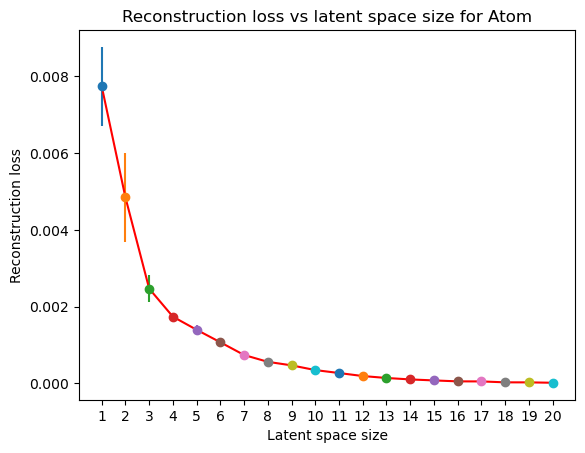

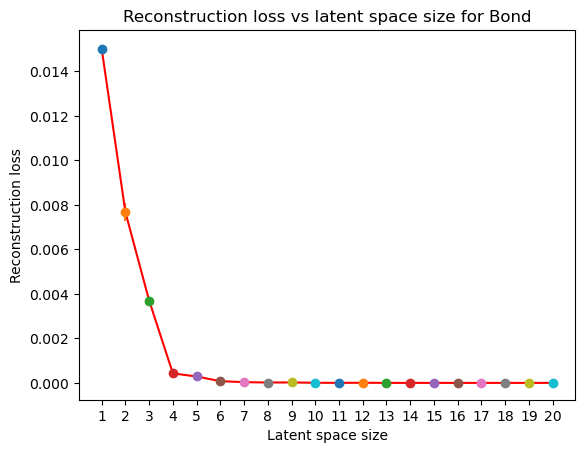

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot
plot_loss_vs_latent_space_size(loss_dictionary_atom_vectors, autoencoder_type="atom")
plot_loss_vs_latent_space_size(loss_dictionary_bond_vectors, autoencoder_type="bond")